In [1]:
import numpy as np
import scipy as sc
import pandas as pd
import ReadFromDB as RDB
from Authenticator import read_auth

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (30,4)

import sklearn as sk
from statsmodels.tsa.arima_model import ARIMA

# Time conversions
from datetime import datetime
convert = lambda x : datetime.utcfromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S')

In [2]:
# reload after changes have been made
from importlib import reload
reload(RDB)
for i in dir(RDB)[8:]:
    print(i,end=', ')

create_station_dictionary, get_static_data, pd, read_auth, read_weather, station, station_dict_row, 

**An Arima time series will be used to generate a plot for each station**

In [3]:
static_data = RDB.get_static_data()
station_numbers = list(static_data['number'].astype(int))

In [4]:
# make a model for each station individually. 
# for snum in station_numbers:
# strat with model for station number 5.    

In [5]:
weather = RDB.read_weather(5)
# weather.head(1)

In [6]:
station_data = RDB.station(5)
# station_data.head(1)

In [13]:
# remove any data where the station is closed
station_data = station_data[station_data.status=='OPEN']

# convert timestamps from milliseconds to seconds and change type to int
make_timestamp = lambda x: int(x/1000)
station_data.last_updated = station_data.last_updated.apply(make_timestamp)

# set timestamp as index
station_data.set_index('last_updated', inplace=True)

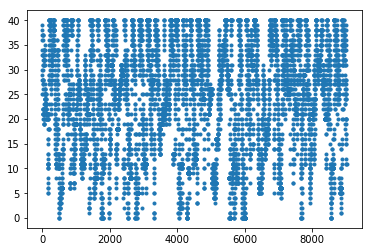

In [8]:
plt.plot(station_data.available_bike_stands, '.')

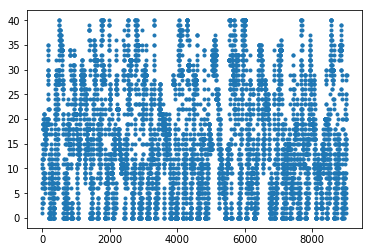

In [9]:
plt.plot(station_data.available_bikes,'.')

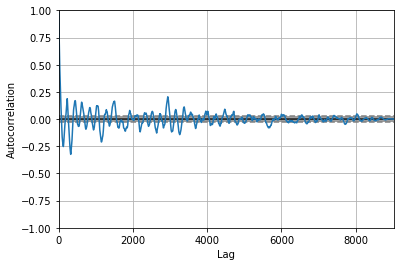

In [10]:
pd.plotting.autocorrelation_plot(station_data.available_bikes)

Autocorrelation plots are often used for checking randomness in time series. This is done by computing autocorrelations for data values at varying time lags. If time series is random, such autocorrelations should be near zero for any and all time-lag separations. If time series is non-random then one or more of the autocorrelations will be significantly non-zero. The horizontal lines displayed in the plot correspond to 95% and 99% confidence bands. The dashed line is 99% confidence band. See the Wikipedia entry for more about autocorrelation plots.

**Model Application**

In [14]:
model = ARIMA(station_data.available_bikes, order=(5,0,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

C:\Users\Ciaran\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                              ARMA Model Results                              
Dep. Variable:        available_bikes   No. Observations:                 9023
Model:                     ARMA(5, 0)   Log Likelihood              -20597.251
Method:                       css-mle   S.D. of innovations              2.372
Date:                Wed, 03 Apr 2019   AIC                          41208.503
Time:                        20:52:03   BIC                          41258.256
Sample:                             0   HQIC                         41225.430
                                                                              
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    16.0610      0.977     16.432      0.000      14.145      17.977
ar.L1.available_bikes     1.1044      0.011    104.934      0.000       1.084       1.125
ar.L2.av

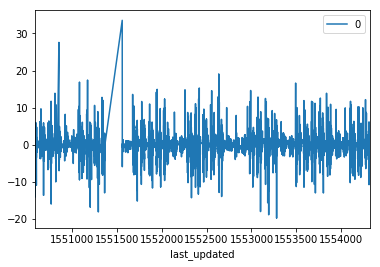

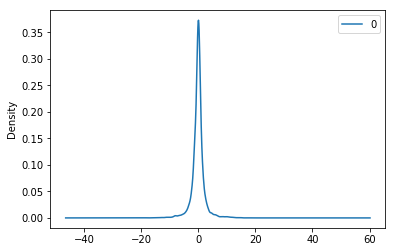

                 0
count  9023.000000
mean      0.001277
std       2.376311
min     -19.756088
25%      -0.782561
50%       0.023893
75%       0.695069
max      33.521969


In [16]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())